# TIme Series Analysis 

## Импортирование библиотек

In [162]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import requests
import json

## Загрузка Данных

В stock в зависимости от компании вписываем нужное значение 

Для TESLA - 'TSLA'

Для YANDEX - 'YNDX'

In [170]:
stock = 'YNDX'
stock_info = pd.read_csv("{}.csv".format(stock))
stock_info['price'] = stock_info['Close']
stock_info = stock_info.drop(columns=['Adj Close', 'Open', 'High', 'Low', 'Volume', 'Close'])
timeseries = pd.Series(stock_info['price'])

## Разделение Данных на тренировочную и тестовую выборки

In [186]:
train = timeseries.head(timeseries.size * 9 // 10 - 10)
test = timeseries.tail(timeseries.size - timeseries.size * 9 // 10 + 10)

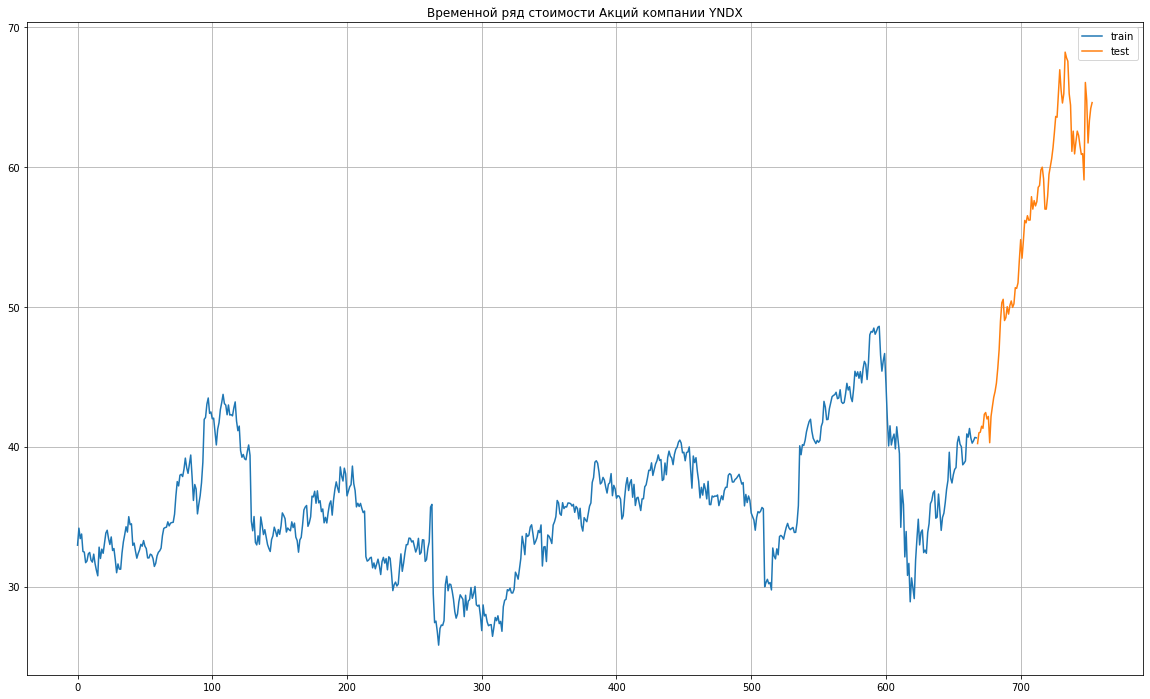

In [187]:
plt.figure(figsize=(20, 12))
plt.grid(True)
plt.title('Временной ряд стоимости Акций компании {}'.format(stock))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.show()

In [188]:
error_table = pd.DataFrame(columns=['MA', 'SimpleExpSm', 'SARIMA', 'Holt', 'ExpSm'],
                           index=['MSE', 'MAE', 'MAPE'])

def count_mse(y, S):
    return mean_squared_error(y, S)

def count_mae(y, S):
    return mean_absolute_error(y, S)

def count_mape(y, S):
    mape = 0
    y = list(y)
    S = list(S)
    for i in range(len(y)):
        mape += abs(y[i] - S[i]) / y[i]
    return mape / len(y)

# Moving Average

MA2 MSE=90.609
MA3 MSE=93.857
MA4 MSE=92.165
MA5 MSE=95.332
MA6 MSE=103.900
MA7 MSE=110.080
MA8 MSE=114.140
MA9 MSE=116.854
MA10 MSE=119.962
MA11 MSE=121.986
MA12 MSE=123.775
MA13 MSE=124.908
MA14 MSE=122.845
MA15 MSE=119.423
MA16 MSE=117.869
MA17 MSE=116.759
MA18 MSE=115.168
MA19 MSE=112.698
Best ARIMA2 MSE=90.609


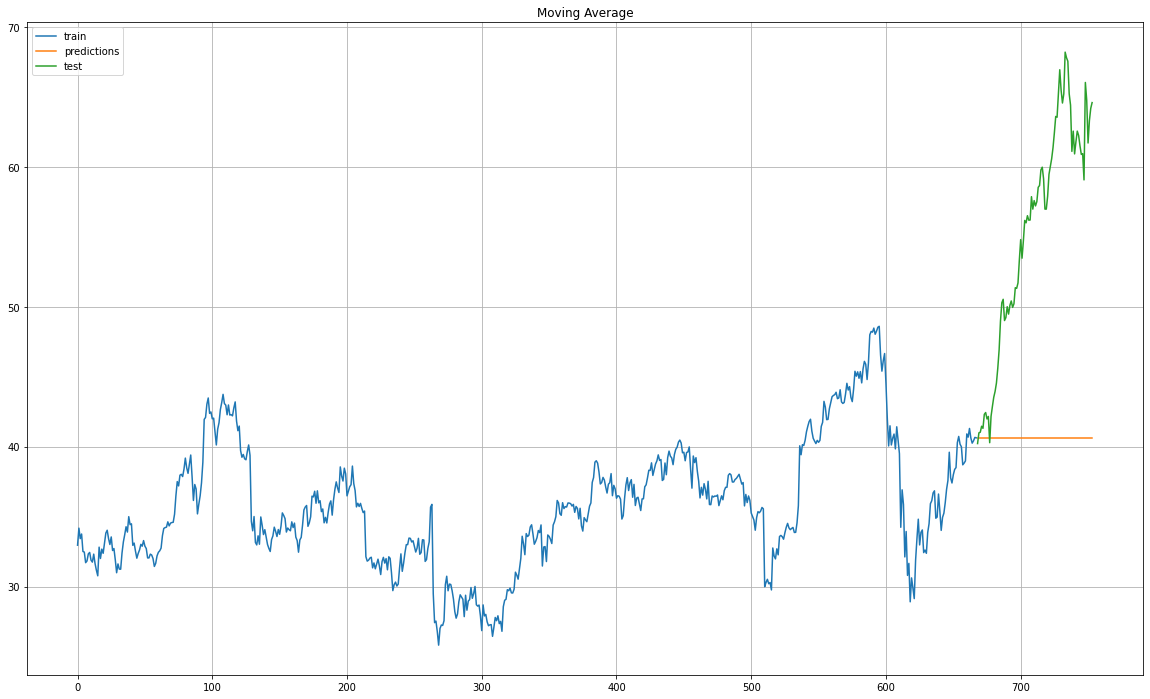

MSE =  285.02735313407504
MAE =  14.833606430232564
MAPE =  0.25017369393191174


In [189]:
def evaluate_ma_model(X, p):
    X = X.astype('float32')
    train_size = int(len(X) * 0.90)
    train, test = X.head(train_size), X.tail(X.size - train_size)
    prediction = train.tail(p).mean()
    mse = mean_squared_error(test, [prediction] * (X.size - train_size))
    return mse

p_values = range(2, 20)

best_score, best_cfg = float("inf"), None
for p in p_values:
        mse = evaluate_ma_model(train, p)
        if mse < best_score:
            best_score, best_cfg = mse, p
        print('MA%s MSE=%.3f' % (p, mse))
print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

predictions = [train.tail(best_cfg).mean()] * test.size

plt.figure(figsize=(20, 12))
plt.grid(True)
plt.title('Moving Average')
plt.plot(train, label='train')
plt.plot(range(train.size, stock_info.shape[0]), predictions, label='predictions')
plt.plot(test, label='test')
plt.legend()
plt.show()

mse = count_mse(test, predictions)
mae = count_mae(test, predictions)
mape = count_mape(test, predictions)
error_table['MA']['MSE'] = mse
error_table['MA']['MAE'] = mae
error_table['MA']['MAPE'] = mape

print("MSE = ", mse)
print("MAE = ", mae)
print("MAPE = ", mape)

## Simple Exponential Smoothing 

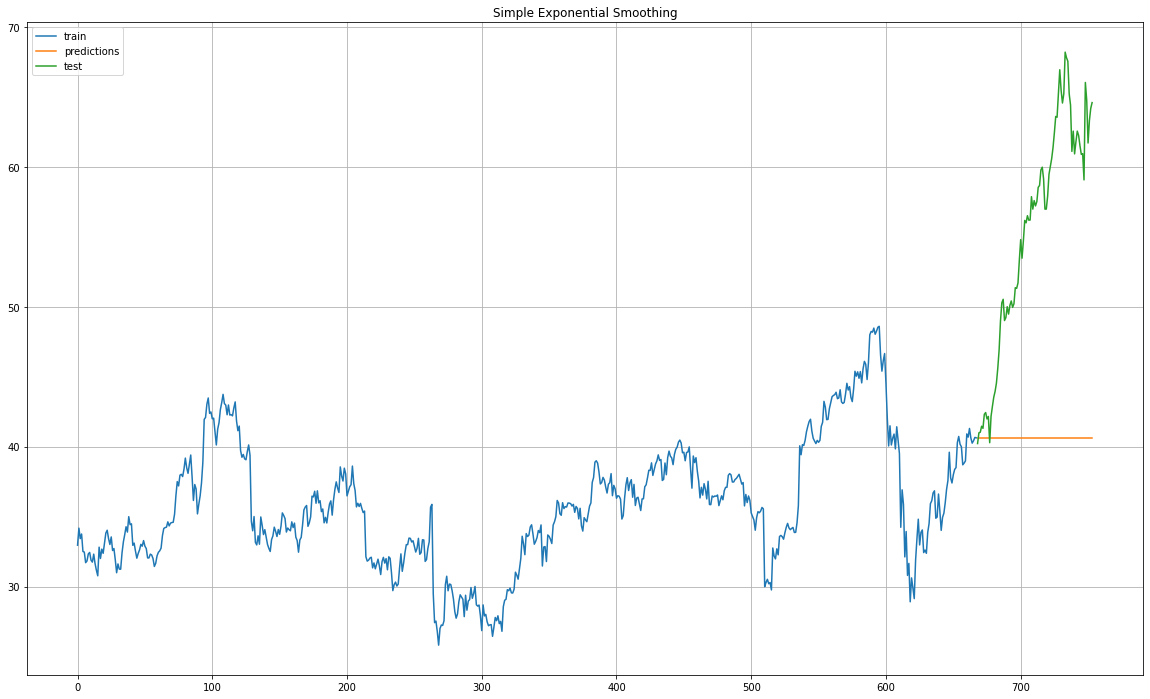

MSE =  285.4465609876577
MAE =  14.847089819428952
MAPE =  0.2504183293878882


In [190]:
model = SimpleExpSmoothing(train, initialization_method="estimated")
fit = model.fit()
predictions = fit.forecast(test.size)


plt.figure(figsize=(20, 12))
plt.grid(True)
plt.title('Simple Exponential Smoothing')
plt.plot(train, label='train')
plt.plot(predictions, label='predictions')
plt.plot(test, label='test')
plt.legend()
plt.show()

mse = count_mse(test, predictions)
mae = count_mae(test, predictions)
mape = count_mape(test, predictions)
error_table['SimpleExpSm']['MSE'] = mse
error_table['SimpleExpSm']['MAE'] = mae
error_table['SimpleExpSm']['MAPE'] = mape

print("MSE = ", mse)
print("MAE = ", mae)
print("MAPE = ", mape)

## Holt

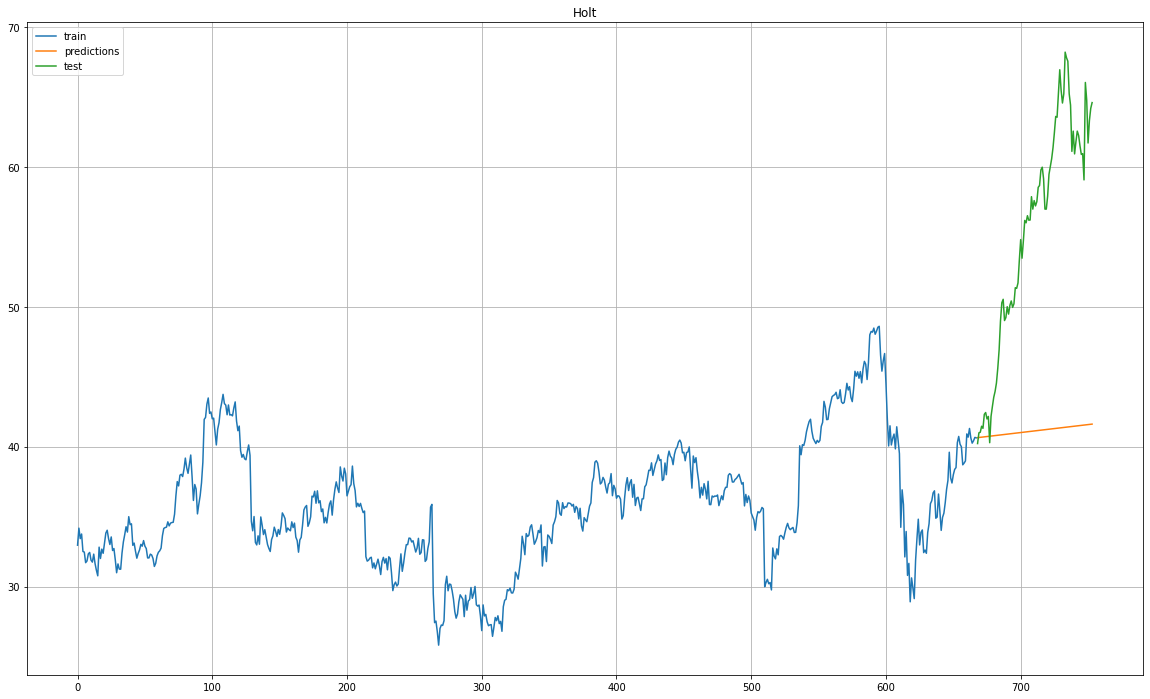

MSE =  266.76621586653636
MAE =  14.353661751977087
MAPE =  0.24209965282245757


In [191]:
model = Holt(train)
fit = model.fit()
predictions = fit.forecast(test.size)

plt.figure(figsize=(20, 12))
plt.grid(True)
plt.title('Holt')
plt.plot(train, label='train')
plt.plot(predictions, label='predictions')
plt.plot(test, label='test')
plt.legend()
plt.show()

mse = count_mse(test, predictions)
mae = count_mae(test, predictions)
mape = count_mape(test, predictions)
error_table['Holt']['MSE'] = mse
error_table['Holt']['MAE'] = mae
error_table['Holt']['MAPE'] = mape

print("MSE = ", mse)
print("MAE = ", mae)
print("MAPE = ", mape)

## Exponential Smoothing

In [192]:
def evaluate_expsm_model(X, p):
    X = X.astype('float32')
    train_size = int(len(X) * 0.90)
    train, test = X.head(train_size), X.tail(X.size - train_size)
    model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=p)
    fit = model.fit()
    prediction = fit.forecast(test.size)
    mse = mean_squared_error(test, prediction)
    return mse

periods_value = range(2, 50)

best_score, best_period = float("inf"), None
for p in periods_value:
    mse = evaluate_expsm_model(train, p)
    if mse < best_score:
        best_score, best_period = mse, p
    print('ExpSm with period %s MSE=%.3f' % (p, mse))

print('Best ExpSm with period %s MSE=%.3f' % (best_period, best_score))

ExpSm with period 2 MSE=80.886
ExpSm with period 3 MSE=81.709
ExpSm with period 4 MSE=79.981
ExpSm with period 5 MSE=81.847
ExpSm with period 6 MSE=80.779
ExpSm with period 7 MSE=81.891
ExpSm with period 8 MSE=78.009
ExpSm with period 9 MSE=80.633
ExpSm with period 10 MSE=82.985
ExpSm with period 11 MSE=79.487
ExpSm with period 12 MSE=74.878
ExpSm with period 13 MSE=80.884
ExpSm with period 14 MSE=80.025
ExpSm with period 15 MSE=91.912
ExpSm with period 16 MSE=80.898
ExpSm with period 17 MSE=83.193
ExpSm with period 18 MSE=82.626
ExpSm with period 19 MSE=81.705
ExpSm with period 20 MSE=79.277
ExpSm with period 21 MSE=79.780
ExpSm with period 22 MSE=82.345
ExpSm with period 23 MSE=79.253
ExpSm with period 24 MSE=77.213
ExpSm with period 25 MSE=84.038
ExpSm with period 26 MSE=86.044
ExpSm with period 27 MSE=75.833
ExpSm with period 28 MSE=80.459
ExpSm with period 29 MSE=80.187
ExpSm with period 30 MSE=88.535
ExpSm with period 31 MSE=84.611
ExpSm with period 32 MSE=84.636
ExpSm with perio

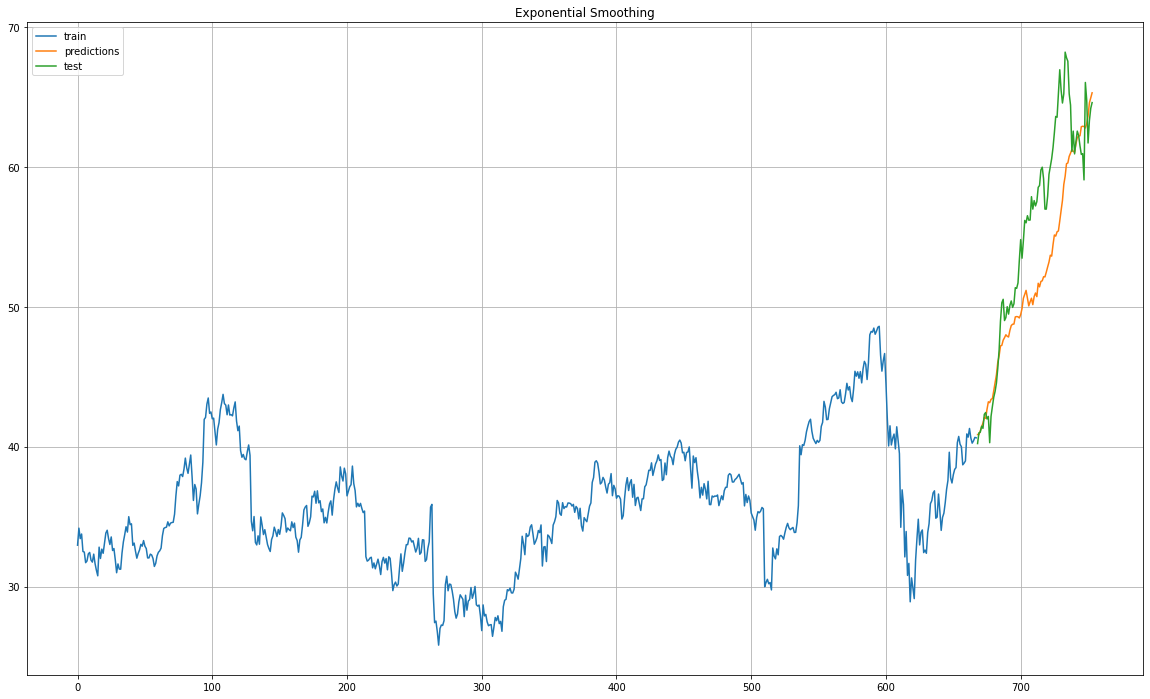

MSE =  22.054984085655608
MAE =  3.648679100890017
MAPE =  0.06215601404072724


In [195]:
model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=p)
fit = model.fit()
predictions = fit.forecast(test.size)

plt.figure(figsize=(20, 12))
plt.grid(True)
plt.title('Exponential Smoothing')
plt.plot(train, label='train')
plt.plot(predictions, label='predictions')
plt.plot(test, label='test')
plt.legend()
plt.show()

mse = count_mse(test, predictions)
mae = count_mae(test, predictions)
mape = count_mape(test, predictions)
error_table['ExpSm']['MSE'] = mse
error_table['ExpSm']['MAE'] = mae
error_table['ExpSm']['MAPE'] = mape

print("MSE = ", mse)
print("MAE = ", mae)
print("MAPE = ", mape)

## SARIMA

In [183]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = list(X[0:train_size]), list(X[train_size:])
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = mse ** 0.5
    return rmse


p_values = range(3)
d_values = range(3)
q_values = range(3)

warnings.filterwarnings("ignore")
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                mse = evaluate_arima_model(train, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.3f' % (order,mse))
            except:
                continue
print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

ARIMA(0, 0, 0) MSE=4.925
ARIMA(0, 0, 1) MSE=2.779
ARIMA(0, 0, 2) MSE=2.090
ARIMA(0, 1, 0) MSE=1.010
ARIMA(0, 1, 1) MSE=1.007
ARIMA(0, 1, 2) MSE=1.011
ARIMA(0, 2, 0) MSE=1.526
ARIMA(0, 2, 1) MSE=1.012
ARIMA(0, 2, 2) MSE=1.010
ARIMA(1, 0, 0) MSE=1.006
ARIMA(1, 0, 1) MSE=1.006
ARIMA(1, 0, 2) MSE=1.009
ARIMA(1, 1, 0) MSE=1.007
ARIMA(1, 1, 1) MSE=1.014
ARIMA(1, 1, 2) MSE=1.002
ARIMA(1, 2, 0) MSE=1.255
ARIMA(1, 2, 1) MSE=1.010
ARIMA(1, 2, 2) MSE=1.014
ARIMA(2, 0, 0) MSE=1.006
ARIMA(2, 0, 1) MSE=1.007
ARIMA(2, 0, 2) MSE=1.000
ARIMA(2, 1, 0) MSE=1.011
ARIMA(2, 1, 1) MSE=1.001
ARIMA(2, 1, 2) MSE=0.995
ARIMA(2, 2, 0) MSE=1.169
ARIMA(2, 2, 1) MSE=1.014
Best ARIMA(2, 1, 2) MSE=0.995


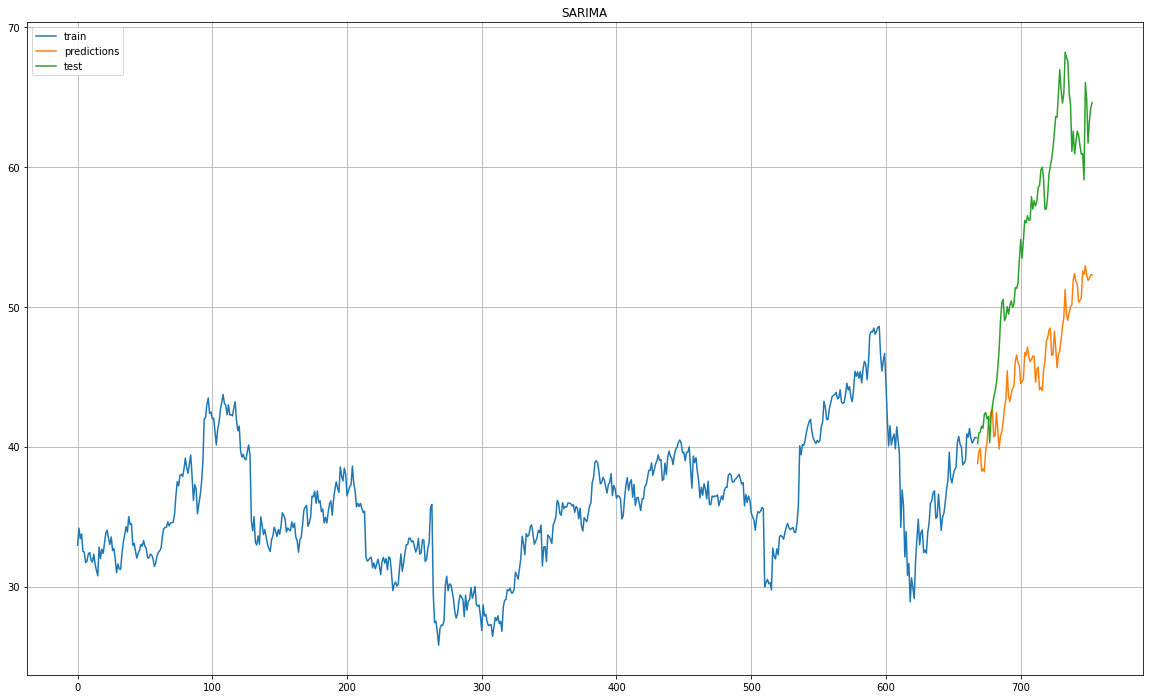

MSE =  115.5377282325806
MAE =  9.531862383763551
MAPE =  0.16262198491586252


In [200]:
model = SARIMAX(train, order=best_cfg, seasonal_order=(*best_cfg, best_period))
fit = model.fit()
predictions = fit.forecast(test.size)


plt.figure(figsize=(20, 12))
plt.grid(True)
plt.title('SARIMA')
plt.plot(train, label='train')
plt.plot(range(train.size, stock_info.shape[0]), predictions, label='predictions')
plt.plot(test, label='test')
plt.legend()
plt.show()

mse = count_mse(test, predictions)
mae = count_mae(test, predictions)
mape = count_mape(test, predictions)
error_table['SARIMA']['MSE'] = mse
error_table['SARIMA']['MAE'] = mae
error_table['SARIMA']['MAPE'] = mape

print("MSE = ", mse)
print("MAE = ", mae)
print("MAPE = ", mape)

In [201]:
error_table

,MA,SimpleExpSm,SARIMA,Holt,ExpSm
MSE,285.027,285.447,115.538,266.766,22.055
MAE,14.8336,14.8471,9.53186,14.3537,3.64868
MAPE,0.250174,0.250418,0.162622,0.2421,0.062156
